In [5]:
import pandas as pd
import numpy as np
import FinanceDataReader as fdr
import matplotlib.pyplot as plt

In [6]:
amzn_df = fdr.DataReader('AMZN', start='1997')
amzn_df.to_csv('AMAZON.csv')

In [7]:
df = pd.read_csv('AMAZON.csv',index_col='Date', parse_dates=['Date'])

In [8]:
df.head()

,Close,Open,High,Low,Volume,Change
Date,,,,,,
1997-05-15,1.96,2.44,2.50,1.93,72160000.0,-0.9962
1997-05-16,1.73,1.97,1.98,1.71,14700000.0,-0.1173
1997-05-19,1.71,1.76,1.77,1.62,6110000.0,-0.0116
1997-05-20,1.64,1.73,1.75,1.64,5470000.0,-0.0409
1997-05-21,1.43,1.64,1.65,1.37,18850000.0,-0.1280


In [9]:
df[df.isin([np.nan, np.inf, -np.inf]).any(1)]

,Close,Open,High,Low,Volume,Change
Date,,,,,,


<AxesSubplot:xlabel='Date'>

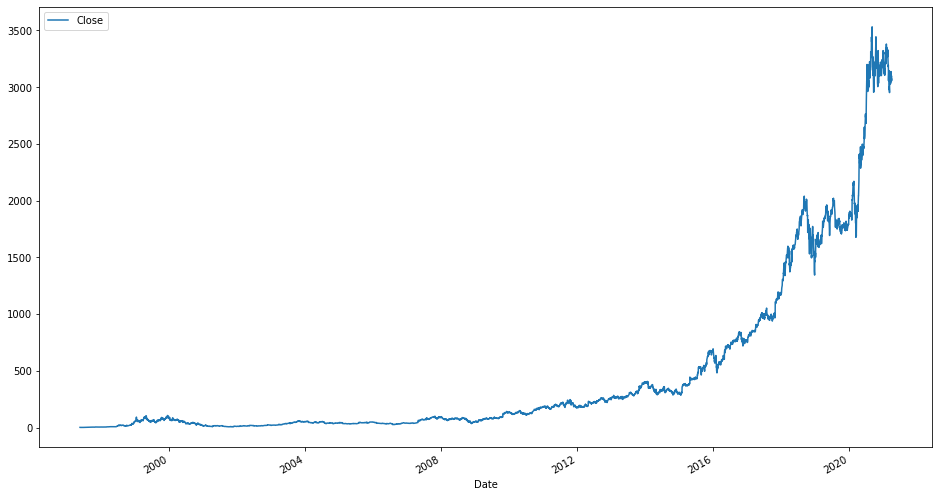

In [11]:
price_df = df.loc[:, ['Close']].copy()
price_df.plot(figsize=(16,9))

<AxesSubplot:xlabel='Date'>

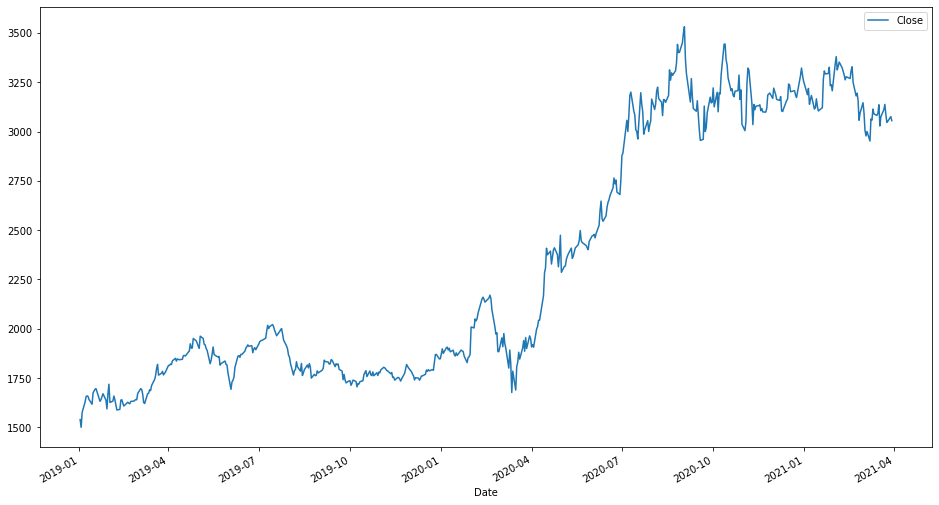

In [13]:
from_date = '2019-01-01'
to_date = '2021-03-30'
price_df.loc[from_date:to_date].plot(figsize=(16,9))

In [14]:
price_df['daily_rtn'] = price_df['Close'].pct_change()
price_df.head(10)

,Close,daily_rtn
Date,,
1997-05-15,1.96,NaN
1997-05-16,1.73,-0.117347
1997-05-19,1.71,-0.011561
1997-05-20,1.64,-0.040936
1997-05-21,1.43,-0.128049
1997-05-22,1.40,-0.020979
1997-05-23,1.50,0.071429
1997-05-27,1.58,0.053333
1997-05-28,1.53,-0.031646


In [16]:
price_df['st_rtn'] = (1+price_df['daily_rtn']).cumprod()
price_df.tail(10)

,Close,daily_rtn,st_rtn
Date,,,
2021-03-18,3027.99,-0.034359,1544.892857
2021-03-19,3074.96,0.015512,1568.857143
2021-03-22,3110.87,0.011678,1587.178571
2021-03-23,3137.50,0.008560,1600.765306
2021-03-24,3087.07,-0.016073,1575.035714
2021-03-25,3046.26,-0.013220,1554.214286
2021-03-26,3052.03,0.001894,1557.158163
2021-03-29,3075.73,0.007765,1569.250000
2021-03-30,3055.29,-0.006646,1558.821429


누적 수익:  1.6355044348828123


<AxesSubplot:xlabel='Date'>

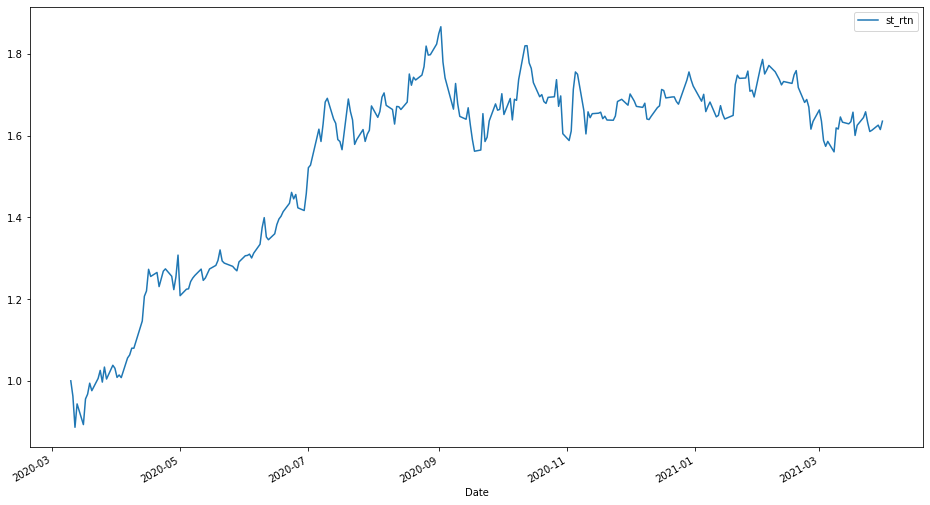

In [21]:
base_date = '2020-03-10'
tmp_df = price_df.loc[base_date:, ['st_rtn']]/price_df.loc[base_date, ['st_rtn']]
last_date = tmp_df.index[-1]
print('누적 수익: ',tmp_df.loc[last_date, 'st_rtn'])
tmp_df.plot(figsize=(16,9))

# GACR(연평균 복리 수익율, Compound Annual Growth Rate)
수익율 성과를 분석할 때 사용하는 지표로 기하평균을 활용한다.
일 데이터를 사용했으므로 전체 연도를 구하기 위해 전체 데이터 기간을 252(금융공학에서 1년은 252영업일로 계산)로 나눈 역수를 제곱 연산한다.

In [28]:
def GACR(df):
    last_date = df.index[-1]
    return df.loc[last_date, 'st_rtn'] ** (252./len(df.index))-1

GACR = GACR(price_df)

# MDD(최대 낙폭)
최대 낙폭 지수는 투자 기간에 고점부터 저점까지 떨어진 낙폭 중 최댓값을 의미한다. 이는 투자자가 겪을 수 있는 고통을 측정하는 지표로 사용되며 낮을수록 좋다.
MDD = (TroughValue - PeakValue) / PeakValue

**pandas tip**
누적 최댓값(Cumulative Maximum): cummax()
누적 최소값(cumulative minimum): cummin()

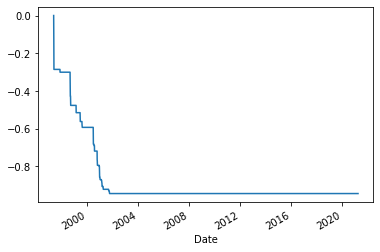

In [29]:
historical_max = price_df['Close'].cummax() 
daily_drawdown = price_df['Close'] / historical_max - 1.0
historical_dd = daily_drawdown.cummin()
historical_dd.plot()
MDD = historical_dd.min()

# Vol(변동성)
주가 변화 수익율 관점의 변동성을 구해본다. 변동성은 금융 자산의 방향성에 대한 불확실성과 가격 등락에 대한 위험 예상 지표로 해석하며, 수익ㅇㄹ의 표준 편차를 변동성으로 계산한다.
변동성은 수익율의 표준 편차로 계산한다. 이는 일 단위 변동성을 의미하는데, 루이 바슐리에의 '투기 이론'에서 주가의 변동폭은 시간의 제곱근에 비례한다는 연구 결과에 따라 일 단위 변동성을 연율화할 때 252의 제곱근을 곱한다.

In [30]:
def VOL(price_df):
    return np.std(price_df['daily_rtn'])*np.sqrt(252.)
VOL = VOL(price_df)

# 샤프 지수
William Sharpe교수가 1966년에 개발한 투자 성과 판단용 지수이다. 어떤 투자의 수익률, 그리고 그 투자에 대한 벤치마크가 되는 자산의 수익률을 가지고 계산할 수 있다.

[https://namu.wiki/w/%EC%83%A4%ED%94%84%20%EB%B9%84%EC%9C%A8]
사전적(ex ante) 샤프 비율: (기대되는 투자의 수익률 - 벤치마크 수익률)의 기대값을 (기대되는 투자의 수익률 - 벤치마크 수익률)의 표준편차로 나눈 것.
사후적(ex post) 샤프 비율의 경우에는 기대값이 아닌 (실현된 수익률 - 벤치마크 수익률)의 평균을 사용한다.

In [32]:
def Sharpe(price_df):
    return np.mean(price_df['daily_rtn']) / np.std(price_df['daily_rtn']) * np.sqrt(252.)

Sharpe = Sharpe(price_df)

In [33]:
print('CAGR: ', round(GACR*100,2),'%')
print('Sharpe: ', round(Sharpe,2))
print('VOL: ', round(VOL*100,2),'%')
print('MDD: ', round(-1*MDD*100, 2),'%')

CAGR:  36.18 %
Sharpe:  0.82
VOL:  58.46 %
MDD:  94.4 %
